## CRYSTALS-Kyber: A Baby Kyber implementation on Python 🛸

Hi! it's me, **Nachito**, we see our faces again! (well, actually that's not true, because this is a computer...whatever).

If you enjoyed my first steps, that means you are ready to join me in this new adventure.

Kyber is a Post-Quantum Key-Establishment Mechanism (PQ KEM) base on the Module - Learning with Errors problem

In this notebook I will show you an example of Kyber at an escalated level, called "baby Kyber".

First, some notation. In Kyber we work with a ring of integer coefficient ($mod$ $q$) and grade $n-1$ polynomials.

Each element on a Kyber vector belongs to $R_{q}$, this being:
$$ R_{q} = \mathbb{Z}_q (X) / (X^n  + 1) $$ 
For instance, a polynomial $a_{(X)}$ $\in$ $R_{q}$:
$$  a_{(X)} = \sum_{i=1}^{n-1} = a_i X^i = a_0 + a_1 X + a_2 X^2 + \cdots + a_{n-1}X^{n-1} \qquad (a_i \thinspace mod \thinspace q)$$
Any vector in this example will have $k$ elements, this means, a vector $\mathbf{v}$ in this field could be:
$$ \mathbf{v} \in R_{q}^k \qquad \mathbf{v} = [v_1, v_2, \cdots, v_k]^T \qquad v_i \in R_q \quad i = (1,2,\cdots,k)$$

In our baby kyber example we consider:


| **Parameter**  |   **Value** |
|----------------|:-----------:|
|       $n$      |     4       | 
| $q$            |     17      | 
| $k$            |     2       |

<div style="text-align:center"> note that $q$ is a prime number and chosen to be equal to $2^n + 1$



In [21]:
import numpy as np
q = 17 #module
n = 4 #grade
k = 2 #number of elements

<div style="text-align:center">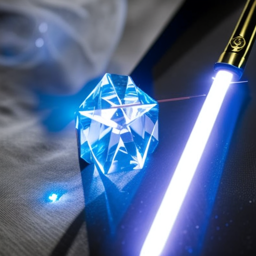
</div>

<div style="text-align:center"> Kyber Crystal being forge by Midjourney<div>

Now let's get down to business.

We can split the Kyber KEM in three steps:
 - **Key Generation**
 - **Encryption**
 - **Decription**
 
In the **Key Generation** step we genete both the public and the secret key $(p_k,s_k)$

$$ p_k: \mathbf{t} = \mathbf{A} \thinspace \mathbf{s} + \mathbf{e}$$
$$ s_k: \mathbf{s}$$

- $\mathbf{A}$ $\in$ $R_q^{k \thinspace x \thinspace k}$ is a polynomial matrix. Each coefficient in $\mathbf{A}$ is uniformly sampled. Kyber standard uses a *PARSE* function to sample this coefficients.


In [33]:
# Generate matrix A from an uniformly random distribution
#---------------------------------------------------------------
A = np.zeros([2, 2, 4], dtype=int)
for i in range(k):
    for j in range(k):
        A[i][j] = np.random.randint(low=0, high=q, size=n)
#  ---------- end of matrix A generation -----------------------
print("Matrix A:")
#print(A)
print("A11:", A[0][0])
print("A12:", A[0][1])
print("A21:", A[1][0])
print("A22:", A[1][1])

Matrix A:
A11: [11 14  5  4]
A12: [14 13 15 16]
A21: [11 15 14 12]
A22: [ 2 13  9  5]


- $\mathbf{s}$ $\in$ $R_q^k$   is the secret key, a noise vector. Noise in Kyber is sample from a Centered Binomial Distribution (CBD).
- $\mathbf{e}$ $\in$ $R_q^k$  is another noise vector, it is the error we add in our M-LWE problem.

#note to the editor (Nachito): add Kyber standar references.


In [34]:
# Generate s , e from an CBD
#---------------------------------------------------------------
trials, p = 10, .5  # number of trials, probability of each trial
l = 4 # array lenght
# Noise vector s:
s = np.zeros((k,l), dtype=int)
for j in range(k):
    a = np.random.binomial(trials, p, l)
    b = np.random.binomial(trials, p, l)
    for i in range(l):
        s[j][i] = a[i] + b[i] - 10
# Noise vector e:
e = np.zeros((k,l), dtype=int)
for j in range(k):
    a = np.random.binomial(trials, p, l)
    b = np.random.binomial(trials, p, l)
    for i in range(l):
        e[j][i] = a[i] + b[i] - 10
# ------------- end noise generation -------------------------------
print("Vector s:")
print(s)
print("Vector e:")
print(e)

Vector s:
[[ 0 -3  0 -1]
 [ 1 -1  0  1]]
Vector e:
[[ 1  3  1  3]
 [-2  2 -1  2]]


In [35]:
#First we multiply the verctor s with A:
Axs = np.zeros((k,l), dtype=int)
poly_mod_negacyclic = np.array([1,0, 0, 0, 1])

for i in range(k):
    for j in range(k):
        aux = np.convolve(A[i][j],s[j])
        aux = aux % q
        [quo, rem] = np.polydiv(aux, poly_mod_negacyclic)
        if (len(rem) < l):
            rem = np.concatenate((np.zeros(1),rem))
        rem = rem % q
        Axs[i] = Axs[i] + rem
Axs = Axs % q
#then we add the error e
t = Axs + e
t = t % q

print("A o s:\n",Axs)
print("public key t:\n",t)
print("secret key s:\n",s)

A o s:
 [[ 6  8 10  1]
 [13  6  0  8]]
public key t:
 [[ 7 11 11  4]
 [11  8 16 10]]
secret key s:
 [[ 0 -3  0 -1]
 [ 1 -1  0  1]]


So far we manage to accomplish the first step of our implementation, so let's move onto the next step: **encryption**

Encrypting requires the public key $\mathbf{t}$ and a message $m$ as input, an generates the ciphertext $c$ as output. In this simple example, we will use the same matrix $\mathbf{A}$ we sample in the **Key Generation** step, but in real Kyber it is generated freshly as part of every encryption.

Let's say we want to send is the number 9, which can be represented as a 4 bit digit in BCD:

the number 9 in binary is 1001 $\rightarrow$ we encode it as a polynomial array:


In [36]:
q2 = 9 #module over two
m_dec = 9
print("message:\n",m_dec)
# ENCODE:
# ----------------------------
m = np.zeros(l, dtype= int)
m_bin = bin(m_dec)
for i in range(l):
    m[i] = int(m_bin[i+2])
print("message as a polynomial array:\n",m)
m = m * q2
#------end of encodig---------
print("endoded message:\n",m)

message:
 9
message as a polynomial array:
 [1 0 0 1]
endoded message:
 [9 0 0 9]


We also need some noise vectors for the ciphertext generation 
- $\mathbf{r}$ $\in$ $R_q^{k}$ is a polynomial noise vector sampled from a CBD:
- $\mathbf{e_1}$ $\in$ $R_q^k$ is a polynomial noise vector sampled from a CBD:
- $\mathbf{e_2}$ $\in$ $R_q$  is a polynomial sampled from a CBD:


In [37]:
# Generate r , e1, e2 from a CBD
#---------------------------------------------------------------
trials, p = 10, .5  # number of trials, probability of each trial
l = 4 # array lenght
# Noise vector s:
r = np.zeros((k,l), dtype=int)
for j in range(k):
    a = np.random.binomial(trials, p, l)
    b = np.random.binomial(trials, p, l)
    for i in range(l):
        r[j][i] = a[i] + b[i] - 10
# Noise vector e:
e1 = np.zeros((k,l), dtype=int)
for j in range(k):
    a = np.random.binomial(trials, p, l)
    b = np.random.binomial(trials, p, l)
    for i in range(l):
        e1[j][i] = a[i] + b[i] - 10
e2 = np.zeros(l, dtype=int)
a = np.random.binomial(trials, p, l)
b = np.random.binomial(trials, p, l)
for i in range(l):
    e2[i] = a[i] + b[i] - 10
# ------------- end noise generation -------------------------------
print("error r:\n", r)
print("error e1:\n", e1)
print("error e2:\n", e2)

error r:
 [[-1 -1  2 -3]
 [ 0  0 -2 -3]]
error e1:
 [[ 4  0  2 -2]
 [ 0 -1  1 -3]]
error e2:
 [-1 -3  0  2]


Kyber ciphertext consist in two values: $\mathbf{u}$, a polynomial vector in $R_q^{k}$, and $v$ a polynomial in $R_q$.

$$ \mathbf{u} = \mathbf{A}^T \thinspace \mathbf{r} + \mathbf{e_1}  $$

$$ v = \mathbf{t}^T \thinspace \mathbf{r} + e_2 + m  $$

To obtain $\mathbf{u}$ first we transpose the matrix $\mathbf{A}$, multiply it by $\mathbf{r}$ 

In [38]:
# Transpose Matrix A:
AT = np.zeros((k,k,l),dtype = int)
AT[0][0] = A[0][0]
AT[1][0] = A[0][1]
AT[0][1] = A[1][0]
AT[1][1] = A[1][1]
print("MATRIX A TRANSPOSE")
print("AT11:", AT[0][0])
print("AT12:", AT[0][1])
print("AT21:", AT[1][0])
print("AT22:", AT[1][1])
# Multiply AT with r
ATxr = np.zeros((k,l), dtype=int)
for i in range(k):
    for j in range(k):
        aux = np.convolve(AT[i][j],r[j])
        aux = aux % q
        [quo, rem] = np.polydiv(aux, poly_mod_negacyclic)
        if (len(rem) < l):
            rem = np.concatenate((np.zeros(1),rem))
        rem = rem % q
        ATxr[i] = ATxr[i] + rem
ATxr = ATxr % q
print("A TRANSPOSE by r:\n",ATxr)

MATRIX A TRANSPOSE
AT11: [11 14  5  4]
AT12: [11 15 14 12]
AT21: [14 13 15 16]
AT22: [ 2 13  9  5]
A TRANSPOSE by r:
 [[ 8  4  3  5]
 [ 6  0 11  9]]


Now, we add the noise vector $\mathbf{e_1}$

In [39]:
#now we add the error e1
u = ATxr + e1
u = u % q
# ---------- end u ------------------------------
print("u:\n",u)

u:
 [[12  4  5  3]
 [ 6 16 12  6]]


To generate te polynomial $v$, we do:

In [40]:
# Obtain v:
# ----------------------------------------------
v = np.zeros(l, dtype=int)
for j in range(k):
    aux = np.convolve(t[j],r[j])
    aux = aux % q
    [quo, rem] = np.polydiv(aux, poly_mod_negacyclic)
    if (len(rem) < l):
        rem = np.concatenate((np.zeros(1),rem))
    rem = rem % q
    v = v + rem
v = v % q
# here i've multiply t^T * r, now we add e2
v = v + e2
v = v % q
# finally we add the encoded message
v = v + m
v = v % q
# ---------- end v ------------------------------
print("ciphertext")
print("u:\n",u)
print("v:\n",v)

ciphertext
u:
 [[12  4  5  3]
 [ 6 16 12  6]]
v:
 [13.  1. 10. 16.]


Finally we implement the **Decryption** step, where we recover the message by doing the following operation:

$$ m = v - \mathbf{s}^T \thinspace \mathbf{u}$$

In [42]:
m_noisy = np.zeros(l, dtype=int)
for j in range(k):
    aux = np.convolve(s[j],u[j])
    aux = aux % q
    [quo, rem] = np.polydiv(aux, poly_mod_negacyclic)
    if (len(rem) < l):
        rem = np.concatenate((np.zeros(1),rem))
    rem = rem % q
    m_noisy = m_noisy + rem
m_noisy = m_noisy % q

m_noisy = v - m_noisy
m_noisy = m_noisy % q
print("Noisy message:\n", m_noisy)
#finally we decode the message:
m = np.zeros(l, dtype=int)
for i in range(len(m_noisy)):
    if (m_noisy[i] >= 5 and m_noisy[i] < 13):
        m[i] = 1
    else:
        m[i] = 0
print("message:\n", m)

Noisy message:
 [ 6. 10. 11. 14.]
message:
 [1 1 1 0]


## Appendix A: convolutions and transforms 🐛 ➡ 🦋

A core concep in our implmentation is **convolution**.

Let $a_{[k]}$ and $b_{[k]}$ be two finite discrete sequences of length $n$, such that:

$$ a[k] = (a[0], a[1],a[2], \cdots,a[n-1]) \qquad b[k] = (b[0], b[1],b[2], \cdots,b[n-1]) $$

The **Lineal** or **acyclic** convolution between this sequences is definded as:

$$ \tilde{z[k]} =  \sum_{k=1}^{n-1} a[i] b[k-i]  $$

Where $\tilde{z}[k]$ is a sequence of length $2n -1$ (this means it has $2n -2 $ elements).

On the one hand the **cyclic** convolution of two sequences of length $n$, $a[k]$ and $b[k]$, can be defined as another length $n$ sequence $z[k]$ such that:

$$ z[k] = \tilde{z}[k] + \tilde{z}[k + n] \qquad where \qquad \thinspace \tilde{z}[2n - 1] = 0$$

On the other hand, the **nega-cyclic** convolution can be defined as another lentgh $n$ sequence $y[k]$ being this one:

$$ y[k] = \tilde{z}[k] - \tilde{z}[k + n] \qquad where \qquad \thinspace \tilde{z}[2n - 1] = 0$$$$


Now, let $A(x)$ and $B(x)$ two polynomials of degree at most $n - 1 $ where:

$$ A(x) =  \sum_{k=1}^{n-1} a[k] x^k \qquad B(x) =  \sum_{k=1}^{n-1} b[k] x^k $$

It is easy to proof that the linear convolution between $ a[k]$ and $b[k]$ hols the multiplication of the polynonials $A(x)$ and $B(x)$

$$ A(x)B(x) = \sum_{k=1}^{2n-2} \tilde{z}[k] x^k $$

